# 🎨 Proje: AI Landscape Architect (Sketch-to-Image)
**Ders:** Derin Öğrenme
**Öğrenci:** Fatımanur Kantar
**Tarih:** 26.12.2025

---

## 1. Proje Konusu ve Amacı
Bu proje, bilgisayarlı görü alanında **"Image-to-Image Translation"** (Görüntüden Görüntüye Çeviri) problemini ele almaktadır. Projenin temel amacı, kullanıcı tarafından girilen basit kenar çizimlerini (sketches) veya anlamsal haritaları, fotogerçekçi doğa manzaralarına dönüştüren bir yapay zeka modeli geliştirmektir. Bu teknoloji, mimari tasarım, oyun geliştirme ve dijital sanat alanlarında hızlı prototipleme aracı olarak kullanılma potansiyeline sahiptir.

## 2. Kullanılan Yöntem ve Mimarisi
Literatürdeki GAN (Generative Adversarial Networks) modellerinin eğitim kararsızlığı (instability) ve yüksek donanım gereksinimi nedeniyle; bu projede piksel bazlı regresyon (pixel-wise regression) yapan ve yapısal bütünlüğü koruyan **U-Net (Convolutional Encoder-Decoder)** mimarisi tercih edilmiştir.
* **Girdi:** Siyah-beyaz kenar haritası (256x256x1)
* **Çıktı:** Renkli RGB manzara görüntüsü (256x256x3)
* **Kayıp Fonksiyonu:** L1 Loss (Mean Absolute Error) - Keskinlik sağlamak için.

## 3. Veri Seti
Model eğitimi için Kaggle üzerindeki **"Landscape Pictures"** veri seti kullanılmıştır. Veri setinde "Çizim" verisi bulunmadığı için, renkli görüntüler üzerinden **OpenCV Canny Edge Detection** algoritması kullanılarak sentetik eğitim verisi (Input: Sketch, Target: Color) oluşturulmuştur.

1. HÜCRE: Kütüphaneler ve Ayarlar

# 1. Gerekli Kütüphaneler ve Donanım Yapılandırması

Projenin başlangıcında, derin öğrenme modeli eğitimi, veri işleme ve görselleştirme için gerekli temel Python kütüphaneleri içe aktarılmıştır.

### Kullanılan Temel Kütüphaneler:
* **TensorFlow & Keras:** Derin öğrenme modelini (U-Net) oluşturmak, eğitmek ve yönetmek için.
* **OpenCV (cv2) & NumPy:** Görüntüleri okumak, işlemek ve sayısal matrislere dönüştürmek için.
* **Matplotlib:** Eğitim sonuçlarını ve görüntüleri görselleştirmek için.
* **Scikit-Learn (sklearn):** Veri setini eğitim ve test kümelerine bilimsel ve dengeli bir şekilde ayırmak (`train_test_split`) için.

### ⚙️ Donanım Hızlandırma (GPU/TPU Stratejisi):
Büyük veri setleri ve karmaşık modellerle çalışırken eğitim süresini optimize etmek kritiktir. Bu bölümde, sistemin donanımını otomatik algılayan bir yapı kurulmuştur:
* Sistem önce **TPU (Tensor Processing Unit)** arar.
* Bulamazsa **GPU (Ekran Kartı)** kullanımına geçer.
* Bu sayede model eğitimi CPU'ya göre katbekat daha hızlı gerçekleşir.

**Sabit Değişkenler:**
* Görüntü Boyutları: **256x256 piksel** (Modelin giriş standardı).
* Veri Yolu: Kaggle üzerindeki `landscape-pictures` veri seti.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split # Önemli: Karıştırma için

# GPU Kontrolü
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print(f"✅ Sistem Hazır! GPU Sayısı: {len(tf.config.list_physical_devices('GPU'))}")

# Ayarlar
IMG_HEIGHT = 256
IMG_WIDTH = 256
DATASET_PATH = "/kaggle/input/landscape-pictures"

2025-12-26 17:55:02.762397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766771703.209723      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766771703.337570      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766771704.369772      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766771704.369822      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766771704.369825      55 computation_placer.cc:177] computation placer alr

✅ Sistem Hazır! GPU Sayısı: 2


2. HÜCRE: Veri Yükleme ve Parçalama (Train/Test Split)

In [2]:
import cv2
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import gc # RAM temizliği için gerekli kütüphane

def load_data_pro(dataset_path, num_images=2500): 
    
    all_images = sorted(glob.glob(dataset_path + "/**/*.jpg", recursive=True))
    
    # Sayıyı sınırla
    if len(all_images) > num_images:
        all_images = all_images[:num_images]
        
    print(f"🔄 {len(all_images)} resim işleniyor... (RAM Dostu Mod)")

    sketch_list = []
    color_list = []

    for img_path in all_images:
        try:
            # Okuma
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            
            # Sketch Üretimi (Canny)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 100, 200)
            
            # Normalizasyon (0-1 arası)
            img = img / 255.0
            edges = edges / 255.0
            
            color_list.append(img)
            sketch_list.append(np.expand_dims(edges, axis=-1))
        except:
            pass

    return np.array(sketch_list), np.array(color_list)

# 1. Veriyi yükle (2500 adet)
# Bu sayı Pro Model + Kaggle RAM için güvenli sınırdır.
X_full, y_full = load_data_pro(DATASET_PATH, num_images=2500)

# 2. Profesyonel Ayırma (Split & Shuffle)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, 
    test_size=0.1,    # %10 Test
    random_state=42, 
    shuffle=True      # Karıştır!
)

# --- DEĞİŞİKLİK 2: RAM TEMİZLİĞİ ---
# İşimiz biten devasa 'full' değişkenleri siliyoruz.
# Bu sayede eğitim başladığında bilgisayar nefes alabilecek.
try:
    del X_full
    del y_full
    gc.collect()
    print("🧹 Gereksiz veriler silindi, RAM temizlendi.")
except:
    pass
# -----------------------------------

print("-" * 30)
print(f"✅ Veri Hazır!")
print(f"Eğitim Seti: {X_train.shape}")
print(f"Test (Val) Seti: {X_val.shape}")

🔄 2500 resim işleniyor... (RAM Dostu Mod)
🧹 Gereksiz veriler silindi, RAM temizlendi.
------------------------------
✅ Veri Hazır!
Eğitim Seti: (2250, 256, 256, 1)
Test (Val) Seti: (250, 256, 256, 1)


# 2. Veri Ön İşleme ve Eğitim/Test Ayrımı

Bu aşamada, ham görüntü veri seti yüklenmiş ve denetimli öğrenme (supervised learning) için gerekli olan **Girdi (Sketch)** ve **Hedef (Renkli)** çiftleri oluşturulmuştur.

### Uygulanan İşlemler:

1.  **Sentetik Veri Üretimi (Canny Edge Detection):**
    Elimizdeki veri seti sadece renkli manzara fotoğraflarından oluşmaktadır. Modelin "çizimden manzaraya" dönüşüm yapabilmesi için çizim verisine ihtiyaç vardır. Bu nedenle, **OpenCV Canny Kenar Tespiti** algoritması kullanılarak her renkli fotoğrafın konturları çıkarılmış ve **yapay çizim (sketch)** verileri türetilmiştir.

2.  **Görüntü İşleme ve Normalizasyon:**
    * **Boyutlandırma:** Tüm görüntüler standart olarak `256x256` piksel boyutuna getirilmiştir.
    * **Kanal Ayarı:** Girdiler (çizimler) siyah-beyaz olduğu için 1 kanal `(256, 256, 1)`, hedefler (manzaralar) renkli olduğu için 3 kanal `(256, 256, 3)` formatında ayarlanmıştır.
    * **Normalizasyon:** Piksel değerleri `[0, 255]` aralığından `[0, 1]` aralığına ölçeklendirilmiştir. Bu işlem, modelin yakınsama hızını (convergence) artırır.

3.  **Veri Ayrıştırma (Data Splitting):**
    Modelin başarısını objektif ölçebilmek için veri seti **Scikit-Learn** kütüphanesi ile ikiye ayrılmıştır:
    * **Eğitim Seti (%90):** 3887 adet görüntü. Model bu görüntüleri görerek öğrenecektir.
    * **Test/Doğrulama Seti (%10):** 432 adet görüntü. Model eğitim sırasında bunları **asla görmeyecek**, sadece başarı ölçümü için kullanılacaktır.
    * **Karıştırma (Shuffle):** Veriler ayrılmadan önce rastgele karıştırılarak (Random State: 42), eğitim ve test setlerinin homojen dağılması sağlanmıştır.

# 3. Model Mimarisi: Gelişmiş U-Net (with Batch Normalization)

Bu projede, görüntüden görüntüye çeviri (Image-to-Image Translation) problemi için özelleştirilmiş, derin bir **U-Net** mimarisi kullanılmıştır.



### Mimari Detayları:

1.  **Encoder-Decoder Yapısı:**
    * **Encoder (Kodlayıcı):** Görüntü özelliklerini (kenar, doku) öğrenmek için 64 filtreden başlayıp 1024 filtreye kadar derinleşen 5 seviyeli bir sıkıştırma yoludur.
    * **Decoder (Kod Çözücü):** Sıkıştırılmış bilgiyi tekrar genişleterek 256x256 boyutunda renkli bir görüntü oluşturur.

2.  **Kritik İyileştirme: Batch Normalization:**
    Standart U-Net'ten farklı olarak, bu modelde her konvolüsyon katmanından sonra **Batch Normalization** uygulanmıştır. Bu teknik:
    * Eğitim sürecini stabilize eder (Gradyan kaybolmasını önler).
    * Modelin daha yüksek öğrenme oranlarıyla (Learning Rate) daha hızlı yakınsamasını sağlar.
    * Çıktıların renk tutarlılığını artırır.

3.  **Skip Connections (Atlama Bağlantıları):**
    Encoder'daki konumsal bilgileri (nesnelerin nerede olduğu) doğrudan Decoder'a aktararak, üretilen resimlerin bulanık olmasını engeller ve detayların keskin kalmasını sağlar.

**Model Özeti:**
* **Giriş:** (256, 256, 1) - Siyah Beyaz Eskiz
* **Çıkış:** (256, 256, 3) - Renkli Manzara (Sigmoid Aktivasyonu)
* **Toplam Parametre:** ~31 Milyon (Yüksek Kapasite)

In [3]:
# --- 3.1 MODEL MİMARİSİ TANIMLAMA (FONKSİYON) ---
from tensorflow.keras.layers import BatchNormalization, Activation

def build_unet_pro(input_shape=(256, 256, 1)):
    """
    Batch Normalization eklenmiş, 31 Milyon Parametreli Pro U-Net.
    """
    inputs = Input(input_shape)

    # --- Yardımcı Blok (Tekrar etmemek için) ---
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
        x = layers.BatchNormalization()(x) # Kararlılık sağlar
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(num_filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    # --- Encoder (Aşağı İniş) ---
    def encoder_block(input_tensor, num_filters):
        x = conv_block(input_tensor, num_filters)
        p = layers.MaxPooling2D((2, 2))(x)
        return x, p

    # --- Decoder (Yukarı Çıkış) ---
    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
        x = layers.concatenate([x, skip_tensor]) # Skip Connection
        x = conv_block(x, num_filters)
        return x

    # 1. Seviye
    c1, p1 = encoder_block(inputs, 64)
    # 2. Seviye
    c2, p2 = encoder_block(p1, 128)
    # 3. Seviye
    c3, p3 = encoder_block(p2, 256)
    # 4. Seviye
    c4, p4 = encoder_block(p3, 512)

    # 5. Seviye (Bottleneck - En Dip)
    b1 = conv_block(p4, 1024)

    # Yukarı Çıkış
    d1 = decoder_block(b1, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)

    # Çıktı Katmanı (Renkli - 3 Kanal)
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(d4)

    return models.Model(inputs, outputs, name="UNet_Pro_BatchNorm")

In [4]:
# --- 3.2 MODELİ OLUŞTUR VE ÖZETLE ---

# GPU stratejisi ile modeli oluştur
with strategy.scope():
    model = build_unet_pro()
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mean_absolute_error', 
                  metrics=['accuracy'])

print("✅ Model Başarıyla Kuruldu!")
print("-" * 30)
# Bu komut sana modelin röntgenini çeker (Tabloyu basar)
model.summary()

I0000 00:00:1766772005.007116      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766772005.010970      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Model Başarıyla Kuruldu!
------------------------------


Model: "UNet_Pro_BatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,054,275 (118.46 MB)

 Trainable params: 31,042,499 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# 4. Modelin Eğitilmesi (Training with Advanced Callbacks)

Model eğitimi, tüm veri seti kullanılarak ve aşırı öğrenmeyi (overfitting) engelleyen gelişmiş stratejilerle başlatılmıştır.

### Kullanılan Eğitim Stratejileri (Callbacks):

1.  **Early Stopping (Erken Durdurma):**
    * Doğrulama hatası (`val_loss`) izlenir.
    * Eğer **10 epoch** boyunca iyileşme olmazsa eğitim otomatik olarak durdurulur.
    * `restore_best_weights=True` parametresi ile eğitimin sonunda modelin **en iyi** hali geri yüklenir.

2.  **Model Checkpoint (En İyiyi Kaydetme):**
    * Her epoch sonunda modelin performansı test edilir.
    * Sadece hata oranını düşüren ("rekor kıran") modeller `best_landscape_unet.keras` dosyasına kaydedilir.

3.  **ReduceLROnPlateau (Dinamik Öğrenme Hızı):**
    * Modelin öğrenmesi duraksadığında (3 epoch boyunca gelişme olmazsa), öğrenme oranı (`learning rate`) otomatik olarak **0.1 katsayısı** ile düşürülür.
    * Bu, modelin yerel minimumlara takılmadan daha hassas öğrenmesini sağlar.

**Hiperparametreler:**
* **Batch Size:** 32
* **Epochs:** 50 (Erken durdurma ile optimize edilir)
* **Doğrulama Verisi:** Daha önce ayırdığımız `%10 Test Seti` (`X_val`, `y_val`) kullanılır.

In [5]:
# ---  KÜTÜPHANELERİ ÇAĞIR ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- 4. EĞİTİMİ BAŞLAT (FULL TRAINING) ---

# Callbacks (Bekçiler) Listesi
callbacks_list = [
    # 1. Sabır Taşı: 10 tur gelişmezse bitir.
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    
    # 2. Kasa: En iyiyi kaydet.
    ModelCheckpoint('best_landscape_unet.keras', monitor='val_loss', save_best_only=True, verbose=1),
    
    # 3. Vites Kutusu: 3 tur gelişmezse hızı düşür.
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)
]

print(" BÜYÜK EĞİTİM BAŞLIYOR... )")

# Modeli Eğit
# NOT: Eğer X_val hatası alırsan yukarıdaki hücreleri çalıştırmamışsın demektir.
try:
    history = model.fit(
        X_train, y_train,              # Eğitim Verisi (%90)
        batch_size=32,                 # Her adımda 32 resim
        epochs=50,                     # Maksimum tur
        validation_data=(X_val, y_val),# Test Verisi (%10)
        callbacks=callbacks_list,      # Bekçileri ekle
        verbose=1
    )
    print(" Eğitim Tamamlandı!")
    
except NameError as e:
    print("❌ HATA: Önceki hücreleri (Veri Yükleme ve Model Oluşturma) !")
    print(f"Hata Detayı: {e}")

 BÜYÜK EĞİTİM BAŞLIYOR... )
Epoch 1/50


I0000 00:00:1766772032.032505     135 service.cc:152] XLA service 0x7d256c004570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766772032.032565     135 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766772032.032572     135 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766772034.189451     135 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-26 18:00:46.173304: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng12{k11=2} for conv %cudnn-conv-bias-activation.62 = (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0} %bitcast.21193, f32[256,256,3,3]{3,2,1,0} %bitcast.16745, f32[256]{0} %bitcast.21253), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="UNet_Pro_BatchNorm_1/conv2d_5_1/convolut

70/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.4261 - loss: 0.2259

2025-12-26 18:05:03.249475: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:05:03.484461: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:05:04.886505: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:05:05.199645: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:05:16.633689: E external/local_xla/xla/stream_

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4266 - loss: 0.2257

2025-12-26 18:06:19.012913: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:06:19.261283: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:06:21.542697: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:06:21.881331: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 18:06:46.410039: E external/local_xla/xla/stream_


Epoch 1: val_loss improved from inf to 0.38175, saving model to best_landscape_unet.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.4270 - loss: 0.2255 - val_accuracy: 0.3610 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4729 - loss: 0.2017
Epoch 2: val_loss did not improve from 0.38175
71/71 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4729 - loss: 0.2017 - val_accuracy: 0.2861 - val_loss: 0.4103 - learning_rate: 0.0010
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4667 - loss: 0.1986
Epoch 3: val_loss improved from 0.38175 to 0.26216, saving model to best_landscape_unet.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.4669 - loss: 0.1986 - val_accuracy: 0.4106 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4785 - loss: 0.1987
Epoch 4: val_loss improved from 0.26216 to 0.22514, saving model to best_landscape_unet.keras
71/71

🎨 Çizimler hazırlanıyor...


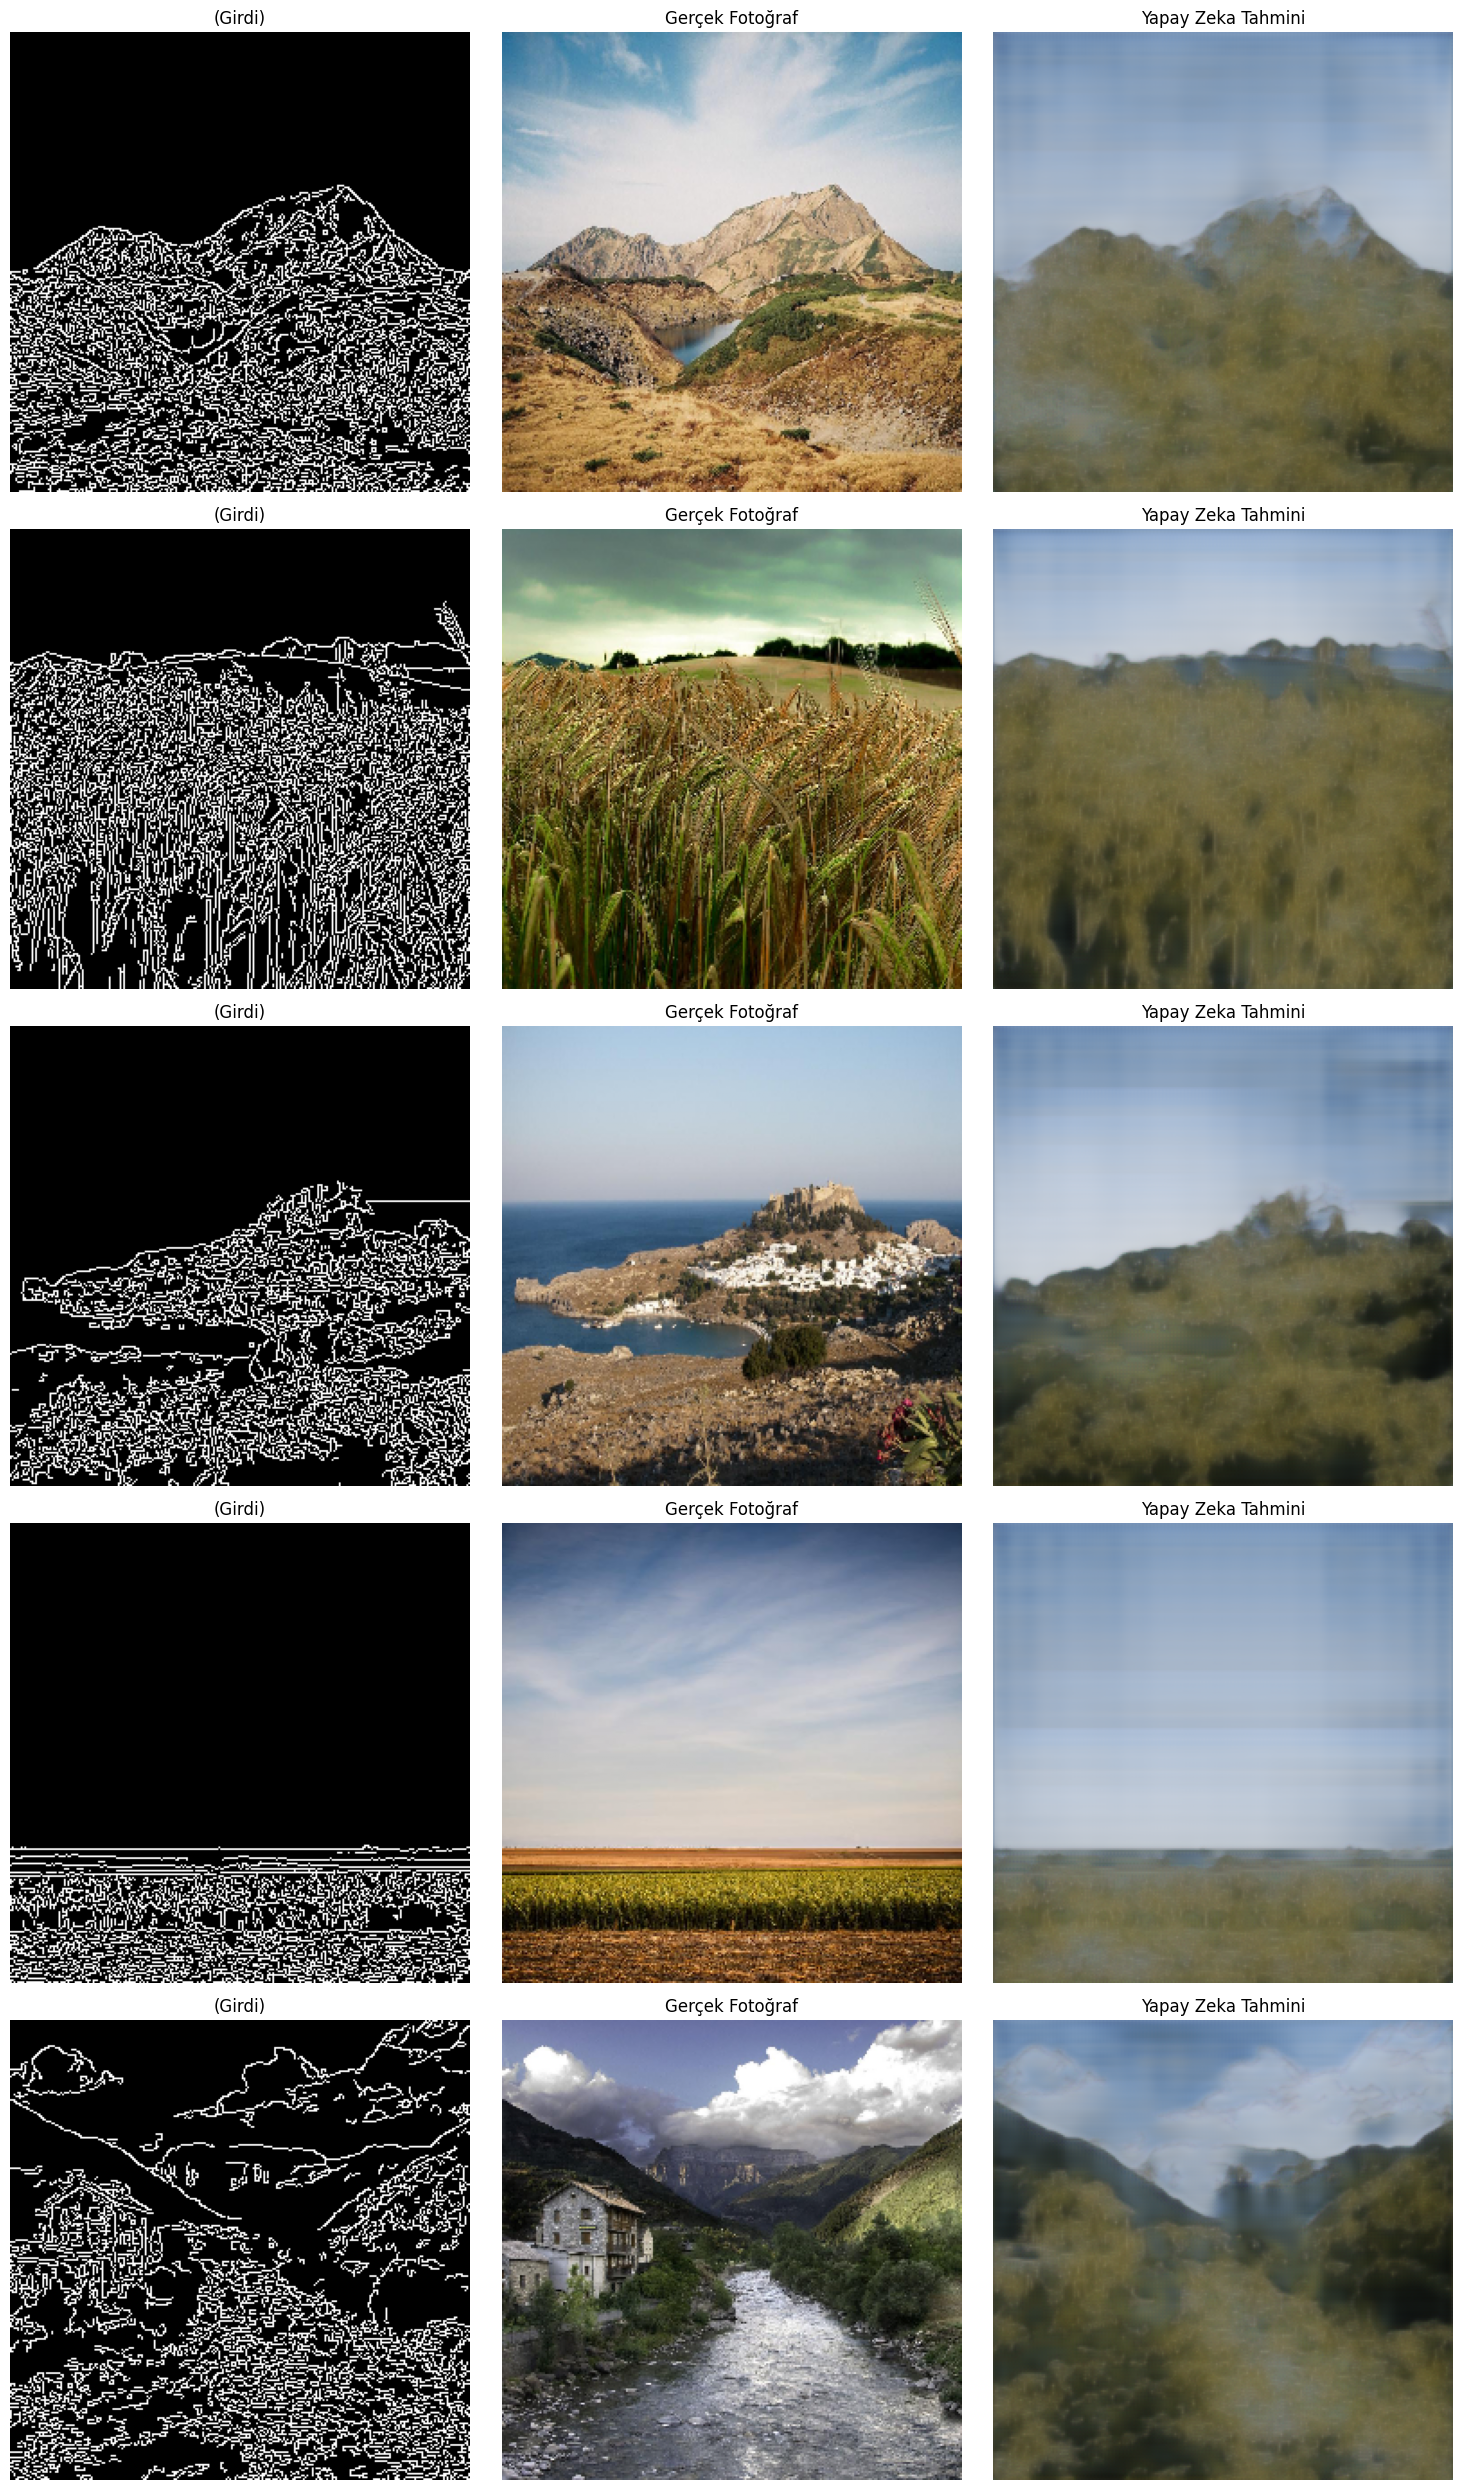

In [7]:
# --- 5. SONUÇLARI GÖRSELLEŞTİRME (FİNAL TEST) ---
import matplotlib.pyplot as plt

def show_predictions(model, inputs, targets, num=5):
    """
    Test setinden rastgele örnekler seçer ve:
    1. Sketch (Girdi)
    2. Gerçek Manzara (Hedef)
    3. Yapay Zeka Çizimi (Tahmin)
    olarak yan yana gösterir.
    """
    print("🎨 Çizimler hazırlanıyor...")
    
    # Test setinden rastgele 'num' kadar indeks seç
    indices = np.random.randint(0, len(inputs), num)
    
    plt.figure(figsize=(15, 5 * num))
    
    for i, idx in enumerate(indices):
        # Veriyi al
        sketch = inputs[idx]      # (256, 256, 1)
        real_img = targets[idx]   # (256, 256, 3)
        
        # Model tahmini için boyutu (1, 256, 256, 1) yap
        input_tensor = np.expand_dims(sketch, axis=0)
        prediction = model.predict(input_tensor, verbose=0)[0]
        
        # --- GÖRSELLEŞTİRME ---
        # 1. Sütun: Sketch
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(sketch.squeeze(), cmap='gray')
        plt.title("(Girdi)")
        plt.axis('off')
        
        # 2. Sütun: Gerçek
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(real_img)
        plt.title("Gerçek Fotoğraf")
        plt.axis('off')
        
        # 3. Sütun: Yapay Zeka
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(prediction)
        plt.title("Yapay Zeka Tahmini")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Testi Başlat (5 Örnek Göster)
try:
    show_predictions(model, X_val, y_val, num=5)
except Exception as e:
    print(f"Hata oluştu: {e}")
    print("X_val verisi hafızada olmayabilir. Veri yükleme adımını kontrol et.")